In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf, cv2, shutil
from tqdm import tqdm
tqdm.pandas()
import os 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, CSVLogger, ModelCheckpoint
from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.efficientnet import EfficientNetB2, EfficientNetB7

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# shutil.rmtree("/kaggle/working/Image_set/")

In [3]:
test_csv = pd.read_csv('/kaggle/input/age-detection-analytics-vidhya-peter/test_Bh8pGW3/test.csv')
test_csv.shape

(6636, 1)

In [4]:
train_csv = pd.read_csv('/kaggle/input/age-detection-analytics-vidhya-peter/train_DETg9GD/train.csv')
train_csv.shape

(19906, 2)

In [5]:
train_csv['Class'].unique()

array(['MIDDLE', 'YOUNG', 'OLD'], dtype=object)

In [6]:
## To see distribution of different classes
dist = pd.DataFrame(train_csv['Class'].value_counts()/train_csv.shape[0]*100)
# dist.rename(columns = {'Class': 'Percentage'}, inplace = True) ## To replace the columns name 
dist.columns = ['Percentage'] ## To replace the columns name if there is only one column
dist.index = ['MIDDLE', 'OLD', 'YOUNG']
dist.sort_values(by= ['Percentage'], ascending = False)
dist

,Percentage
MIDDLE,54.275093
OLD,33.688335
YOUNG,12.036572


(array([0, 1, 2]),
 [Text(0, 0, 'MIDDLE'), Text(1, 0, 'YOUNG'), Text(2, 0, 'OLD')])

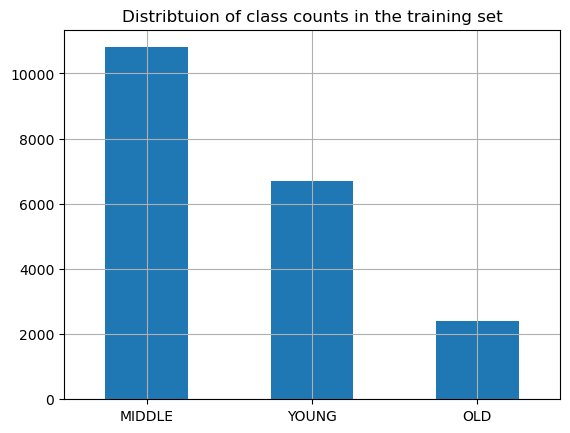

In [7]:
train_csv['Class'].value_counts(dropna = False).plot(kind = 'bar',grid = True)
plt.title("Distribtuion of class counts in the training set")
plt.xticks(rotation = 0)

In [8]:
train_csv.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [9]:
## Label Encoding
label_encoder = preprocessing.LabelEncoder()
train_csv['Class'] = label_encoder.fit_transform(train_csv['Class'])
train_csv['Class'].unique()

array([0, 2, 1])

In [10]:
train_csv.head()

,ID,Class
0,377.jpg,0
1,17814.jpg,2
2,21283.jpg,0
3,16496.jpg,2
4,4487.jpg,0


**Hence, following encoding took place: Middle--> 0, Old--> 1, Young--> 2 (In alphabetical order)**

In [11]:
# Training and validation set splitting
# -----Method 1 for splitting------
# train_csv_valid = train_csv[:6569] ## 0.33 valid set
# train_csv_train = train_csv[6570:] ## 0.66 train set

# -----Method 2 for splitting------
train_csv_valid = train_csv.sample(frac=0.33)
train_csv_train = train_csv.drop(train_csv_valid.index)

print(train_csv_valid.shape)
print(train_csv_train.shape)

(6569, 2)
(13337, 2)


In [12]:
X = train_csv['ID']
X.shape

(19906,)

In [13]:
train_csv_train.head()

,ID,Class
0,377.jpg,0
2,21283.jpg,0
3,16496.jpg,2
6,23495.jpg,2
7,7100.jpg,2


In [14]:
!mkdir /kaggle/working/Image_set/

!mkdir /kaggle/working/Image_set/Train
!mkdir /kaggle/working/Image_set/Train/0
!mkdir /kaggle/working/Image_set/Train/1
!mkdir /kaggle/working/Image_set/Train/2

!mkdir /kaggle/working/Image_set/Valid
!mkdir /kaggle/working/Image_set/Valid/0
!mkdir /kaggle/working/Image_set/Valid/1
!mkdir /kaggle/working/Image_set/Valid/2

!mkdir /kaggle/working/Image_set/Test
!mkdir /kaggle/working/Image_set/Test/test

## Middle- 0, Old- 1, Young- 2

### Resizing and Copying the images into Valid and Train folders

In [15]:
## for training dataset
for index, row in tqdm(train_csv_train.iterrows(),total=len(train_csv_train)):
    image = cv2.imread('/kaggle/input/age-detection-analytics-vidhya-peter/train_DETg9GD/Train/'+row['ID'])
    image = cv2.resize(image,(224,224))
    img_path = "/kaggle/working/Image_set/Train/"+str(row['Class'])+"/"+row['ID']
    save_img(img_path,image)

100%|██████████| 13337/13337 [02:31<00:00, 87.92it/s]


In [16]:
## for validation dataset
for index, row in tqdm(train_csv_valid.iterrows(),total=len(train_csv_valid)):
    image = cv2.imread('/kaggle/input/age-detection-analytics-vidhya-peter/train_DETg9GD/Train/'+row['ID'])
    image = cv2.resize(image,(224,224))
    img_path = "/kaggle/working/Image_set/Valid/"+str(row['Class'])+"/"+row['ID']
    save_img(img_path,image)

100%|██████████| 6569/6569 [01:12<00:00, 90.52it/s] 


In [17]:
##     ------------------------TRAINING AND VALIDATION SET------------------------
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, 
                                  rotation_range = 10, fill_mode = 'nearest',
                                  width_shift_range = 0.2, height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/kaggle/working/Image_set/Train/',
                                target_size = (224,224),
                                batch_size = 16,
                                class_mode = 'categorical',
                                color_mode='rgb')
validation_set = val_datagen.flow_from_directory('/kaggle/working/Image_set/Valid/',
                                target_size = (224,224),
                                batch_size = 16,
                                class_mode = 'categorical',
                                color_mode='rgb')

Found 13337 images belonging to 3 classes.
Found 6569 images belonging to 3 classes.


In [18]:
train_csv_valid.head()

,ID,Class
13820,10550.jpg,2
13633,7318.jpg,1
11550,12314.jpg,2
15326,17450.jpg,2
6406,18863.jpg,2


### Resizing the test image dataset

In [19]:
for index, row in tqdm(test_csv.iterrows(),total=len(test_csv)):
    image = cv2.imread('/kaggle/input/age-detection-analytics-vidhya-peter/test_Bh8pGW3/Test/'+row['ID'])
    image = cv2.resize(image,(224,224))
    img_path = "/kaggle/working/Image_set/Test/test/"+row['ID']
    save_img(img_path,image)

100%|██████████| 6636/6636 [01:14<00:00, 88.58it/s]


In [119]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/kaggle/working/Image_set/Test/',
                                  target_size = (224,224),
                                  batch_size = 16,
                                  class_mode = 'categorical',
                                    color_mode='rgb')

Found 6636 images belonging to 1 classes.


In [23]:
test_csv.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [24]:
# densenet_models = []
# rsnt_models = []
# inception_models = []
# # efnet_models = []

# batch_size = 8
# # To handle image loading problem
# from PIL import Image, ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# X = train_csv['ID']
# y = train_csv['Class']
# skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
# i = 1
# for train_idx, valid_idx in list(skf.split(X,y)):
#     if (i!=1):
#         !mkdir /kaggle/working/Image_set/

#         !mkdir /kaggle/working/Image_set/Train
#         !mkdir /kaggle/working/Image_set/Train/0
#         !mkdir /kaggle/working/Image_set/Train/1
#         !mkdir /kaggle/working/Image_set/Train/2

#         !mkdir /kaggle/working/Image_set/Valid
#         !mkdir /kaggle/working/Image_set/Valid/0
#         !mkdir /kaggle/working/Image_set/Valid/1
#         !mkdir /kaggle/working/Image_set/Valid/2

#     train_csv_train = train_csv.iloc[train_idx]
#     train_csv_valid = train_csv.iloc[valid_idx]

## ------------------------RESIZING THE GIVEN IMAGES AND COPYING THEM TO OUTPUT-----------------------------
#     ## for training dataset
#     for index, row in tqdm(train_csv_train.iterrows(),total=len(train_csv_train)):
#         image_train = cv2.imread('/kaggle/input/age-detection-analytics-vidhya-peter/train_DETg9GD/Train/'+row['ID'])
#         image_train = cv2.resize(image_train,(224,224))
#         img_path_train = "/kaggle/working/Image_set/Train/"+str(row['Class'])+"/"+row['ID']
#         save_img(img_path_train,image_train)
#     ## for validation dataset
#     for index, row in tqdm(train_csv_valid.iterrows(),total=len(train_csv_valid)):
#         image_valid = cv2.imread('/kaggle/input/age-detection-analytics-vidhya-peter/train_DETg9GD/Train/'+row['ID'])
#         image_valid = cv2.resize(image_valid,(224,224))
#         img_path_valid = '/kaggle/working/Image_set/Valid/'+str(row['Class'])+"/"+row['ID']
#         save_img(img_path_valid,image_valid)
        
# #      ------------------------TRAINING AND VALIDATION SET------------------------
#     train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True, 
#                                   rotation_range = 10, fill_mode = 'nearest',
#                                   width_shift_range = 0.2, height_shift_range=0.2)
#     val_datagen = ImageDataGenerator(rescale = 1./255)
#     training_set = train_datagen.flow_from_directory('/kaggle/working/Image_set/Train/',
#                                    target_size = (224,224),
#                                    batch_size = batch_size,
#                                    class_mode = 'categorical',
#                                     color_mode='rgb')
#     validation_set = val_datagen.flow_from_directory('/kaggle/working/Image_set/Valid/',
#                                   target_size = (224,224),
#                                   batch_size = batch_size,
#                                   class_mode = 'categorical',
#                                     color_mode='rgb')
    
# #     ------------------------TRAINING THE MODELS------------------------
#     FC_LAYERS = [1024, 512, 256]
#     dropout = 0.5
#     def build_model(base_model, dropout, fc_layers, num_classes):
#         for layer in base_model.layers:
#             layer.trainable = True

#         x = base_model.output
#         x = Flatten()(x)
#         for fc in fc_layers:
#             print(fc)
#             x = Dense(fc, activation='relu')(x)
#             x = Dropout(dropout)(x)
#         preditions = Dense(num_classes, activation='softmax')(x)
#         finetune_model = Model(inputs = base_model.input, outputs = preditions)
#         return finetune_model

#     base_model_1 = ResNet50(weights = 'imagenet',
#                            include_top = False,
#                            input_shape = (224,224,3))

#     base_model_2 = InceptionV3(weights = 'imagenet',
#                            include_top = False,
#                            input_shape = (224,224, 3))

#     base_model_3 = DenseNet121(weights = 'imagenet',
#                            include_top = False,
#                            input_shape = (224,224, 3))

# #     base_model_4 = EfficientNetB7(include_top= False,
# #                                   weights="imagenet",
# #                                   input_shape=(224,224,3))
    
# #     -----------------------RSNT MODEL-----------------------
#     # Training model
#     Rsnt_model = build_model(base_model_1,
#                             dropout = dropout,
#                             fc_layers = FC_LAYERS,
#                             num_classes = 3)

#     # compiling the model
#     opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001,decay=1e-4)
#     Rsnt_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
    
#     rsnt_models.append(Rsnt_model)
    
#     # fitting the model
#     history_rsnt = Rsnt_model.fit(training_set,
#                              steps_per_epoch = len(training_set),
#                              epochs = 10,
#                              validation_data = validation_set,
#                              validation_steps = len(validation_set),
#                              callbacks=[CSVLogger('/kaggle/working/Rsnt_'+ str(i) + '.csv'),
#                                 ModelCheckpoint(('/kaggle/working/Rsnt_'+ str(i) + '.hdf5'),
#                                 monitor='val_loss', mode='min', save_best_only=True, 
#                                 save_weights_only=False, verbose=0)],
#                              verbose = 1)
    
# # -------------------------INCEPTION MODEL-----------------------
#     # Training model
#     Inception_model = build_model(base_model_2,
#                             dropout = dropout,
#                             fc_layers = FC_LAYERS,
#                             num_classes = 3)

#     # compiling the model
#     opt = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001,decay=1e-4)
#     Inception_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
    
#     inception_models.append(Inception_model)
    
#     # fitting the model
#     history_inception = Inception_model.fit(training_set,
#                              steps_per_epoch = len(training_set),
#                              epochs = 10,
#                              validation_data = validation_set,
#                              validation_steps = len(validation_set),
#                              callbacks=[CSVLogger('/kaggle/working/Inception_'+ str(i) + '.csv'),
#                                 ModelCheckpoint(('/kaggle/working/Inception_'+ str(i) + '.hdf5'),
#                                 monitor='val_loss', mode='min', save_best_only=True, 
#                                 save_weights_only=False, verbose=0)],
#                              verbose = 1)
    
# # -----------------------DENSNET MODEL-----------------------
#     # Training model
#     Densenet_model = build_model(base_model_3,
#                             dropout = dropout,
#                             fc_layers = FC_LAYERS,
#                             num_classes = 3)

#     # compiling the model
#     opt = tf.keras.optimizers.legacy.RMSprop(learning_rate = 0.0001,decay=1e-4)
#     Densenet_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
    
#     densenet_models.append(Densenet_model)
    
#     # fitting the model
#     history_densenet = Densenet_model.fit(training_set,
#                              steps_per_epoch = len(training_set),
#                              epochs = 10,
#                              validation_data = validation_set,
#                              validation_steps = len(validation_set),
#                              callbacks=[CSVLogger('/kaggle/working/Densenet_'+ str(i) + '.csv'),
#                                 ModelCheckpoint(('/kaggle/working/Densenet_'+ str(i) + '.hdf5'),
#                                 monitor='val_loss', mode='min', save_best_only=True, 
#                                 save_weights_only=False, verbose=0)],
#                              verbose = 1)
    
# # -----------------------EFFICIENT MODEL-----------------------
# #     # Training model
# #     Efficientnet_model = build_model(base_model_4,
# #                             dropout = dropout,
# #                             fc_layers = FC_LAYERS,
# #                             num_classes = 3)

# #     # compiling the model
# #     opt = tf.keras.optimizers.legacy.RMSprop(learning_rate = 0.0001,decay=1e-4)
# #     Efficientnet_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
    
# #     efnet_models.append(Efficientnet_model)
    
# #     # fitting the model
# #     history_efficientnet = Efficientnet_model.fit(training_set,
# #                              steps_per_epoch = len(training_set),
# #                              epochs = 10,
# #                              validation_data = validation_set,
# #                              validation_steps = len(validation_set),
# #                              callbacks=[CSVLogger(('/kaggle/working/Efnet_'+ str(i) + '.csv')),
# #                                 ModelCheckpoint(('/kaggle/working/Efnet_'+ str(i) + '.hdf5'),
# #                                 monitor='val_loss', mode='min', save_best_only=True, 
# #                                 save_weights_only=False, verbose=0)],
# #                              verbose = 1)


#     shutil.rmtree("/kaggle/working/Image_set/")   ## To delete all directories present in output
#     i+=1

### Visualizing the distribution of different classes in Train, validation and test set

(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '2'), Text(2, 0, '1')])

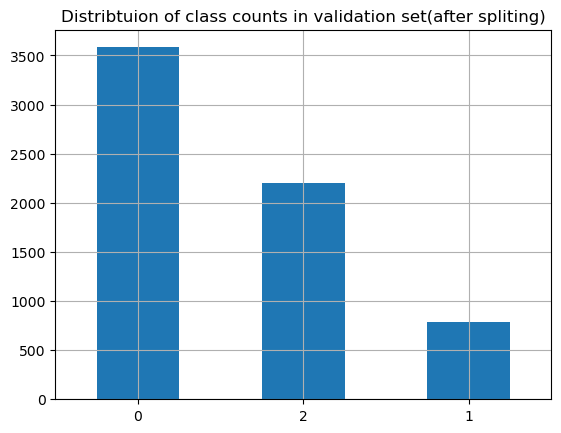

In [25]:
train_csv_valid['Class'].value_counts(dropna = False).plot(kind = 'bar',grid = True)
plt.title("Distribtuion of class counts in validation set(after spliting)")
plt.xticks(rotation = 0)

(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '2'), Text(2, 0, '1')])

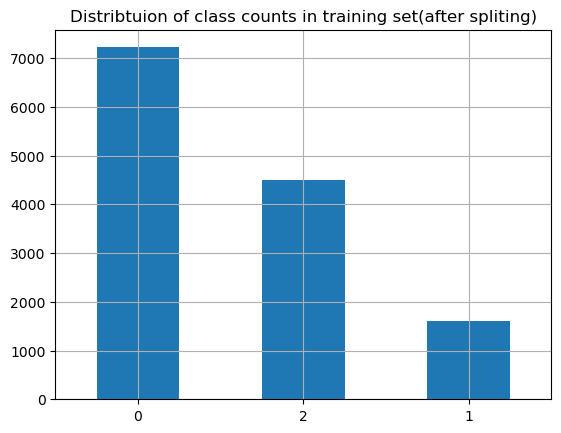

In [26]:
train_csv_train['Class'].value_counts(dropna = False).plot(kind = 'bar',grid = True)
plt.title("Distribtuion of class counts in training set(after spliting)")
plt.xticks(rotation = 0)

## Making Predictions

Loading different models:

In [38]:
dense_model_1 = tf.keras.models.load_model('/kaggle/input/ensembling-models-age-detection-31-03-23/Densenet_1.hdf5')
dense_model_2 = tf.keras.models.load_model('/kaggle/input/ensembling-models-age-detection-31-03-23/Densenet_2.hdf5')
dense_model_3 = tf.keras.models.load_model('/kaggle/input/ensembling-models-age-detection-31-03-23/Densenet_3.hdf5')
dense_model_4 = tf.keras.models.load_model('/kaggle/input/ensembling-models-age-detection-31-03-23/Densenet_4.hdf5')
dense_model_5 = tf.keras.models.load_model('/kaggle/input/ensembling-models-age-detection-31-03-23/Densenet_5.hdf5')

densenet_models = [dense_model_1, dense_model_2, dense_model_3, dense_model_4, dense_model_5]

inception_model_1 = tf.keras.models.load_model('/kaggle/input/inception-age-detection-analytics-vidhya/Inception_1.hdf5')
inception_model_2 = tf.keras.models.load_model('/kaggle/input/inception-age-detection-analytics-vidhya/Inception_2.hdf5')
inception_model_3 = tf.keras.models.load_model('/kaggle/input/inception-age-detection-analytics-vidhya/Inception_3.hdf5')
inception_model_4 = tf.keras.models.load_model('/kaggle/input/inception-age-detection-analytics-vidhya/Inception_4.hdf5')
inception_model_5 = tf.keras.models.load_model('/kaggle/input/inception-age-detection-analytics-vidhya/Inception_5.hdf5')

inception_models = [inception_model_1, inception_model_2, inception_model_3, inception_model_4, inception_model_5]

rsnt_model_1 = tf.keras.models.load_model('/kaggle/input/rsnt-age-detection-analytics-vidhya/Rsnt_1.hdf5')
rsnt_model_2 = tf.keras.models.load_model('/kaggle/input/rsnt-age-detection-analytics-vidhya/Rsnt_2.hdf5')
rsnt_model_3 = tf.keras.models.load_model('/kaggle/input/rsnt-age-detection-analytics-vidhya/Rsnt_3.hdf5')
rsnt_model_4 = tf.keras.models.load_model('/kaggle/input/rsnt-age-detection-analytics-vidhya/Rsnt_4.hdf5')
# rsnt_model_5 = tf.keras.models.load_model('/kaggle/input/rsnt-age-detection-analytics-vidhya/Rsnt_5.hdf5')

rsnt_models = [rsnt_model_1, rsnt_model_2, rsnt_model_3, rsnt_model_4]

Getting ResourceExhausted error for Rsnt_model_5, so I commented it out.

## Max Voting Ensembling method

In [39]:
df_valid = pd.DataFrame([])
i = 1
for item in densenet_models: 
    predictions_dense_valid = pd.DataFrame(np.argmax(item.predict(validation_set), axis = 1))
    temp = 'dense' + str(i)
    df_valid[temp] = predictions_dense_valid
    i+=1

411/411 [==============================] - 22s 49ms/step


In [40]:
i = 1
for item in inception_models: 
    predictions_inception_valid = pd.DataFrame(np.argmax(item.predict(validation_set), axis = 1))
    temp = 'inception' + str(i)
    df_valid[temp] = predictions_inception_valid
    i+=1    

411/411 [==============================] - 18s 40ms/step


In [41]:
i = 1
for item in rsnt_models: 
    predictions_rsnt_valid = pd.DataFrame(np.argmax(item.predict(validation_set), axis = 1))
    temp = 'rsnt' + str(i)
    df_valid[temp] = predictions_rsnt_valid
    i+=1

411/411 [==============================] - 24s 57ms/step


In [42]:
df_valid.head()

,dense1,dense2,dense3,dense4,dense5,inception1,inception2,inception3,inception4,inception5,rsnt1,rsnt2,rsnt3,rsnt4
0,0,2,0,0,0,0,0,2,2,0,0,0,0,1
1,0,0,2,2,2,0,1,2,0,2,0,0,0,0
2,0,0,0,0,2,0,0,0,2,0,0,0,2,0
3,0,0,2,0,0,2,2,0,1,0,1,1,0,2
4,0,2,2,0,2,2,0,0,0,2,2,0,0,2


In [43]:
df_temp = df_valid.mode(axis = 'columns')
df_temp.head()

,0,1
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,2.0


In [44]:
df_temp = df_temp[0]
df_temp.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0, dtype: float64

In [45]:
df_vv = pd.DataFrame(df_temp)
df_vv.head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [46]:
from sklearn.metrics import f1_score
score_f1 = f1_score(df_vv, train_csv_valid['Class'], average = 'weighted')
print(score_f1) ## Using f1_score because the dataset is imbalanced one(having higher number of middle aged actors).

0.6065126403352037


## Average Ensembling method

In [64]:
densenet_valid_avg = pd.DataFrame([])
i = 1
for item in densenet_models: 
    predictions_dense_valid = pd.DataFrame(item.predict(validation_set))
    temp1 = 'dense_0_' + str(i)
    temp2 = 'dense_1_' + str(i)
    temp3 = 'dense_2_' + str(i)
    densenet_valid_avg[temp1] = predictions_dense_valid[0]
    densenet_valid_avg[temp2] = predictions_dense_valid[1]
    densenet_valid_avg[temp3] = predictions_dense_valid[2]
    i+=1

411/411 [==============================] - 20s 49ms/step


In [65]:
densenet_valid_avg.head()

,dense_0_1,dense_1_1,dense_2_1,dense_0_2,dense_1_2,dense_2_2,dense_0_3,dense_1_3,dense_2_3,dense_0_4,dense_1_4,dense_2_4,dense_0_5,dense_1_5,dense_2_5
0,0.000001,7.251727e-12,0.999999,2.696728e-01,1.779822e-02,0.712529,1.000000,3.766041e-08,3.438833e-07,1.000000,2.258652e-26,4.421485e-25,0.782497,2.977399e-02,0.187729
1,0.529616,3.563445e-01,0.114039,2.562369e-03,5.273622e-08,0.997438,0.394574,2.654209e-01,3.400056e-01,0.911239,5.346566e-02,3.529521e-02,0.979114,8.064511e-03,0.012821
2,0.999877,2.965575e-05,0.000093,9.987372e-01,9.927218e-04,0.000270,0.981582,1.287071e-02,5.547458e-03,0.010851,1.736781e-05,9.891319e-01,0.000014,9.341926e-13,0.999986
3,0.935865,4.002669e-03,0.060132,1.011035e-07,4.497884e-18,1.000000,0.347640,1.291245e-02,6.394479e-01,0.076641,9.759510e-04,9.223827e-01,0.035055,1.306084e-04,0.964815
4,0.031572,5.412153e-04,0.967887,4.038218e-01,1.702143e-01,0.425964,1.000000,5.096564e-08,1.447815e-09,0.999999,6.712158e-07,2.234042e-07,0.370026,5.307226e-01,0.099251


In [66]:
inception_valid_avg = pd.DataFrame([])
i = 1
for item in inception_models: 
    inception_valid = pd.DataFrame(item.predict(validation_set))
    temp1 = 'inception_0_' + str(i)
    temp2 = 'inception_1_' + str(i)
    temp3 = 'inception_2_' + str(i)
    inception_valid_avg[temp1] = inception_valid[0]
    inception_valid_avg[temp2] = inception_valid[1]
    inception_valid_avg[temp3] = inception_valid[2]
    i+=1

411/411 [==============================] - 16s 40ms/step


In [67]:
inception_valid_avg.head()

,inception_0_1,inception_1_1,inception_2_1,inception_0_2,inception_1_2,inception_2_2,inception_0_3,inception_1_3,inception_2_3,inception_0_4,inception_1_4,inception_2_4,inception_0_5,inception_1_5,inception_2_5
0,0.088851,0.898362,0.012788,0.696066,0.097916,0.206018,0.003729,0.996150,0.000121,0.003951,0.000117,0.995932,0.916350,0.010462,7.318800e-02
1,0.000622,0.999371,0.000007,0.022077,0.976446,0.001477,0.639461,0.027317,0.333222,0.020173,0.000159,0.979668,0.028124,0.000206,9.716702e-01
2,0.583938,0.014349,0.401714,0.953512,0.028112,0.018376,0.969397,0.004091,0.026512,0.000172,0.999823,0.000005,0.004890,0.994913,1.974966e-04
3,0.137827,0.002476,0.859697,0.645763,0.119978,0.234259,0.846806,0.024152,0.129043,0.999695,0.000020,0.000285,0.999980,0.000019,7.230050e-07
4,0.010746,0.000352,0.988902,0.492837,0.480428,0.026735,0.455153,0.282474,0.262372,0.294109,0.703797,0.002093,0.998445,0.001553,2.576792e-06


In [69]:
rsnt_valid_avg = pd.DataFrame([])
i = 1
for item in rsnt_models: 
    rsnt_valid = pd.DataFrame(item.predict(validation_set))
    temp1 = 'rsnt_0_' + str(i)
    temp2 = 'rsnt_1_' + str(i)
    temp3 = 'rsnt_2_' + str(i)
    rsnt_valid_avg[temp1] = rsnt_valid[0]
    rsnt_valid_avg[temp2] = rsnt_valid[1]
    rsnt_valid_avg[temp3] = rsnt_valid[2]
    i+=1

411/411 [==============================] - 23s 57ms/step


In [70]:
rsnt_valid_avg.head()

,rsnt_0_1,rsnt_1_1,rsnt_2_1,rsnt_0_2,rsnt_1_2,rsnt_2_2,rsnt_0_3,rsnt_1_3,rsnt_2_3,rsnt_0_4,rsnt_1_4,rsnt_2_4
0,0.000111,1.538569e-08,0.999889,0.944049,0.013370,0.042581,0.877745,0.016345,0.105910,0.904426,0.093164,0.002410
1,0.395054,4.357398e-01,0.169206,0.488943,0.055033,0.456024,0.458454,0.294986,0.246560,0.520822,0.408605,0.070573
2,0.022086,1.123954e-04,0.977801,0.026141,0.000033,0.973826,0.007995,0.000018,0.991987,0.998740,0.000357,0.000904
3,0.296418,6.449209e-02,0.639090,0.939016,0.030180,0.030803,0.162075,0.010226,0.827699,0.999645,0.000068,0.000288
4,0.009193,6.731022e-05,0.990740,0.073098,0.000264,0.926638,0.040061,0.002196,0.957743,0.996790,0.000751,0.002459


In [72]:
df_0 = pd.DataFrame()
for i in range(1,6):
    df_0['dense_0_' + str(i)] = densenet_valid_avg['dense_0_' + str(i)]
    df_0['inception_0_' + str(i)] = inception_valid_avg['inception_0_' + str(i)]
    
for i in range(1,5): 
    df_0['rsnt_0_' + str(i)] = rsnt_valid_avg['rsnt_0_' + str(i)]

In [98]:
df_1 = pd.DataFrame()
for i in range(1,6):
    df_1['dense_1_' + str(i)] = densenet_valid_avg['dense_1_' + str(i)]
    df_1['inception_1_' + str(i)] = inception_valid_avg['inception_1_' + str(i)]
    
for i in range(1,5): 
    df_1['rsnt_1_' + str(i)] = rsnt_valid_avg['rsnt_1_' + str(i)]

In [99]:
df_2 = pd.DataFrame()
for i in range(1,6):
    df_2['dense_2_' + str(i)] = densenet_valid_avg['dense_2_' + str(i)]
    df_2['inception_2_' + str(i)] = inception_valid_avg['inception_2_' + str(i)]
    
for i in range(1,5): 
    df_2['rsnt_2_' + str(i)] = rsnt_valid_avg['rsnt_2_' + str(i)]

In [101]:
df_0['mean'] = df_0.mean(axis = 1)
df_0.head()

,dense_0_1,inception_0_1,dense_0_2,inception_0_2,dense_0_3,inception_0_3,dense_0_4,inception_0_4,dense_0_5,inception_0_5,rsnt_0_1,rsnt_0_2,rsnt_0_3,rsnt_0_4,mean
0,0.000001,0.088851,2.696728e-01,0.696066,1.000000,0.003729,1.000000,0.003951,0.782497,0.916350,0.000111,0.944049,0.877745,0.904426,0.534818
1,0.529616,0.000622,2.562369e-03,0.022077,0.394574,0.639461,0.911239,0.020173,0.979114,0.028124,0.395054,0.488943,0.458454,0.520822,0.385060
2,0.999877,0.583938,9.987372e-01,0.953512,0.981582,0.969397,0.010851,0.000172,0.000014,0.004890,0.022086,0.026141,0.007995,0.998740,0.468424
3,0.935865,0.137827,1.011035e-07,0.645763,0.347640,0.846806,0.076641,0.999695,0.035055,0.999980,0.296418,0.939016,0.162075,0.999645,0.530173
4,0.031572,0.010746,4.038218e-01,0.492837,1.000000,0.455153,0.999999,0.294109,0.370026,0.998445,0.009193,0.073098,0.040061,0.996790,0.441132


In [102]:
df_1['mean'] = df_1.mean(axis = 1)
df_1.head()

,dense_1_1,inception_1_1,dense_1_2,inception_1_2,dense_1_3,inception_1_3,dense_1_4,inception_1_4,dense_1_5,inception_1_5,rsnt_1_1,rsnt_1_2,rsnt_1_3,rsnt_1_4,mean
0,7.251727e-12,0.898362,1.779822e-02,0.097916,3.766041e-08,0.996150,2.258652e-26,0.000117,2.977399e-02,0.010462,1.538569e-08,0.013370,0.016345,0.093164,0.155247
1,3.563445e-01,0.999371,5.273622e-08,0.976446,2.654209e-01,0.027317,5.346566e-02,0.000159,8.064511e-03,0.000206,4.357398e-01,0.055033,0.294986,0.408605,0.277226
2,2.965575e-05,0.014349,9.927218e-04,0.028112,1.287071e-02,0.004091,1.736781e-05,0.999823,9.341926e-13,0.994913,1.123954e-04,0.000033,0.000018,0.000357,0.146837
3,4.002669e-03,0.002476,4.497884e-18,0.119978,1.291245e-02,0.024152,9.759510e-04,0.000020,1.306084e-04,0.000019,6.449209e-02,0.030180,0.010226,0.000068,0.019259
4,5.412153e-04,0.000352,1.702143e-01,0.480428,5.096564e-08,0.282474,6.712158e-07,0.703797,5.307226e-01,0.001553,6.731022e-05,0.000264,0.002196,0.000751,0.155240


In [103]:
df_2['mean'] = df_2.mean(axis = 1)
df_2.head()

,dense_2_1,inception_2_1,dense_2_2,inception_2_2,dense_2_3,inception_2_3,dense_2_4,inception_2_4,dense_2_5,inception_2_5,rsnt_2_1,rsnt_2_2,rsnt_2_3,rsnt_2_4,mean
0,0.999999,0.012788,0.712529,0.206018,3.438833e-07,0.000121,4.421485e-25,0.995932,0.187729,7.318800e-02,0.999889,0.042581,0.105910,0.002410,0.309935
1,0.114039,0.000007,0.997438,0.001477,3.400056e-01,0.333222,3.529521e-02,0.979668,0.012821,9.716702e-01,0.169206,0.456024,0.246560,0.070573,0.337715
2,0.000093,0.401714,0.000270,0.018376,5.547458e-03,0.026512,9.891319e-01,0.000005,0.999986,1.974966e-04,0.977801,0.973826,0.991987,0.000904,0.384739
3,0.060132,0.859697,1.000000,0.234259,6.394479e-01,0.129043,9.223827e-01,0.000285,0.964815,7.230050e-07,0.639090,0.030803,0.827699,0.000288,0.450567
4,0.967887,0.988902,0.425964,0.026735,1.447815e-09,0.262372,2.234042e-07,0.002093,0.099251,2.576792e-06,0.990740,0.926638,0.957743,0.002459,0.403628


In [105]:
df_mean = pd.DataFrame()
df_mean['mean_0'] = df_0['mean']
df_mean['mean_1'] = df_1['mean']
df_mean['mean_2'] = df_2['mean']
df_mean.head()

,mean_0,mean_1,mean_2
0,0.534818,0.155247,0.309935
1,0.385060,0.277226,0.337715
2,0.468424,0.146837,0.384739
3,0.530173,0.019259,0.450567
4,0.441132,0.155240,0.403628


In [112]:
df_class = pd.DataFrame(np.argmax(np.array(df_mean), axis = 1))
df_class.head(20)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,2


In [113]:
from sklearn.metrics import f1_score
score_f1_avg = f1_score(df_class, train_csv_valid['Class'], average = 'weighted')
print(score_f1_avg)

0.5902497250922047


## Predictions on the Test set

In [120]:
densenet_test_avg = pd.DataFrame([])
i = 1
for item in densenet_models: 
    predictions_dense_final = pd.DataFrame(item.predict(test_set))
    temp1 = 'dense_0_' + str(i)
    temp2 = 'dense_1_' + str(i)
    temp3 = 'dense_2_' + str(i)
    densenet_test_avg[temp1] = predictions_dense_final[0]
    densenet_test_avg[temp2] = predictions_dense_final[1]
    densenet_test_avg[temp3] = predictions_dense_final[2]
    i+=1

415/415 [==============================] - 21s 50ms/step


In [121]:
inception_test_avg = pd.DataFrame([])
i = 1
for item in inception_models: 
    predictions_inception_test = pd.DataFrame(item.predict(test_set))
    temp1 = 'inception_0_' + str(i)
    temp2 = 'inception_1_' + str(i)
    temp3 = 'inception_2_' + str(i)
    inception_test_avg[temp1] = predictions_inception_test[0]
    inception_test_avg[temp2] = predictions_inception_test[1]
    inception_test_avg[temp3] = predictions_inception_test[2]
    i+=1

415/415 [==============================] - 17s 40ms/step


In [122]:
rsnt_test_avg = pd.DataFrame([])
i = 1
for item in rsnt_models: 
    predictions_rsnt_test = pd.DataFrame(item.predict(test_set))
    temp1 = 'rsnt_0_' + str(i)
    temp2 = 'rsnt_1_' + str(i)
    temp3 = 'rsnt_2_' + str(i)
    rsnt_test_avg[temp1] = predictions_rsnt_test[0]
    rsnt_test_avg[temp2] = predictions_rsnt_test[1]
    rsnt_test_avg[temp3] = predictions_rsnt_test[2]
    i+=1

415/415 [==============================] - 24s 57ms/step


In [123]:
df_0_final = pd.DataFrame()
for i in range(1,6):
    df_0_final['dense_0_' + str(i)] = densenet_test_avg['dense_0_' + str(i)]
    df_0_final['inception_0_' + str(i)] = inception_test_avg['inception_0_' + str(i)]
    
for i in range(1,5): 
    df_0_final['rsnt_0_' + str(i)] = rsnt_test_avg['rsnt_0_' + str(i)]

In [124]:
df_1_final = pd.DataFrame()
for i in range(1,6):
    df_1_final['dense_1_' + str(i)] = densenet_test_avg['dense_1_' + str(i)]
    df_1_final['inception_1_' + str(i)] = inception_test_avg['inception_1_' + str(i)]
    
for i in range(1,5): 
    df_1_final['rsnt_1_' + str(i)] = rsnt_test_avg['rsnt_1_' + str(i)]

In [125]:
df_2_final = pd.DataFrame()
for i in range(1,6):
    df_2_final['dense_2_' + str(i)] = densenet_test_avg['dense_2_' + str(i)]
    df_2_final['inception_2_' + str(i)] = inception_test_avg['inception_2_' + str(i)]
    
for i in range(1,5): 
    df_2_final['rsnt_2_' + str(i)] = rsnt_test_avg['rsnt_2_' + str(i)]

In [126]:
df_0_final['mean'] = df_0_final.mean(axis = 1)
df_0_final.head()

,dense_0_1,inception_0_1,dense_0_2,inception_0_2,dense_0_3,inception_0_3,dense_0_4,inception_0_4,dense_0_5,inception_0_5,rsnt_0_1,rsnt_0_2,rsnt_0_3,rsnt_0_4,mean
0,0.000212,0.430154,0.990396,0.347257,2.518612e-07,0.794583,0.465666,0.821725,0.398201,0.976229,0.878285,0.016504,0.121295,0.992293,0.516629
1,1.000000,0.046780,0.037863,0.010968,4.275818e-01,0.898918,0.780127,0.997621,0.000262,0.999880,0.428096,0.245365,0.465165,0.985060,0.523120
2,0.000003,0.913106,0.396068,0.998413,1.000000e+00,0.982225,0.003241,0.005891,0.222230,0.520729,0.396112,0.699152,0.973402,0.452002,0.540184
3,0.000002,0.230005,0.473873,0.403294,9.999930e-01,0.153911,0.735277,0.000471,0.998988,0.004184,0.817123,0.203685,0.998804,0.417578,0.459799
4,0.363967,0.999678,0.693693,0.000285,9.960134e-01,0.839995,0.451795,0.006205,0.999875,0.934881,0.967065,0.033564,0.267109,0.662332,0.586890


In [127]:
df_1_final['mean'] = df_1_final.mean(axis = 1)
df_1_final.head()

,dense_1_1,inception_1_1,dense_1_2,inception_1_2,dense_1_3,inception_1_3,dense_1_4,inception_1_4,dense_1_5,inception_1_5,rsnt_1_1,rsnt_1_2,rsnt_1_3,rsnt_1_4,mean
0,1.010266e-08,0.018309,0.007421,6.245164e-01,2.421971e-16,0.005483,0.329857,0.085142,5.072331e-01,0.001465,0.024590,0.000047,0.005153,0.005720,0.115353
1,1.967496e-15,0.002820,0.000039,8.823012e-05,1.886541e-01,0.003022,0.090896,0.002103,5.262478e-10,0.000067,0.371928,0.001452,0.533336,0.012502,0.086208
2,2.016400e-11,0.084143,0.394594,2.978855e-04,2.406311e-09,0.003160,0.000002,0.000018,1.312654e-02,0.001622,0.267008,0.017091,0.010066,0.001142,0.056591
3,4.724936e-12,0.206079,0.122580,5.867873e-01,6.635757e-06,0.041373,0.046693,0.999524,9.536719e-05,0.000053,0.090787,0.009419,0.000239,0.565731,0.190669
4,3.408339e-01,0.000203,0.132758,8.712857e-08,3.351069e-03,0.061732,0.272143,0.000025,9.698231e-06,0.057312,0.022846,0.000016,0.009619,0.306172,0.086216


In [128]:
df_2_final['mean'] = df_2_final.mean(axis = 1)
df_2_final.head()

,dense_2_1,inception_2_1,dense_2_2,inception_2_2,dense_2_3,inception_2_3,dense_2_4,inception_2_4,dense_2_5,inception_2_5,rsnt_2_1,rsnt_2_2,rsnt_2_3,rsnt_2_4,mean
0,9.997882e-01,0.551537,0.002183,0.028227,9.999998e-01,0.199935,0.204477,0.093132,0.094566,0.022306,0.097125,0.983449,0.873552,0.001987,0.368019
1,2.458406e-15,0.950400,0.962098,0.988944,3.837641e-01,0.098060,0.128978,0.000276,0.999738,0.000053,0.199976,0.753183,0.001499,0.002438,0.390672
2,9.999970e-01,0.002750,0.209338,0.001289,2.377872e-10,0.014615,0.996757,0.994091,0.764643,0.477648,0.336879,0.283757,0.016532,0.546856,0.403225
3,9.999979e-01,0.563915,0.403548,0.009919,3.133133e-07,0.804717,0.218030,0.000004,0.000916,0.995763,0.092089,0.786896,0.000957,0.016692,0.349532
4,2.951993e-01,0.000118,0.173548,0.999715,6.356231e-04,0.098273,0.276063,0.993770,0.000116,0.007807,0.010089,0.966420,0.723272,0.031496,0.326894


In [129]:
df_mean_final = pd.DataFrame()
df_mean_final['mean_0'] = df_0_final['mean']
df_mean_final['mean_1'] = df_1_final['mean']
df_mean_final['mean_2'] = df_2_final['mean']
df_mean_final.head()

,mean_0,mean_1,mean_2
0,0.516629,0.115353,0.368019
1,0.523120,0.086208,0.390672
2,0.540184,0.056591,0.403225
3,0.459799,0.190669,0.349532
4,0.586890,0.086216,0.326894


In [130]:
df_class_final = pd.DataFrame(np.argmax(np.array(df_mean_final), axis = 1), columns = ['Class'])
df_class_final.head(20)

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [131]:
df_final = df_class_final.replace([0,1,2], ['MIDDLE', 'OLD', 'YOUNG'])
df_final.head()

,Class
0,MIDDLE
1,MIDDLE
2,MIDDLE
3,MIDDLE
4,MIDDLE


In [138]:
test_df_final = pd.concat([df_final, test_csv], axis = 1)
test_df_final.head(20)

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg
5,MIDDLE,19851.jpg
6,MIDDLE,10384.jpg
7,MIDDLE,24567.jpg
8,MIDDLE,2029.jpg
9,MIDDLE,4956.jpg


In [139]:
test_df_final.to_csv('submission.csv', index = False)